In [83]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from projectnb import ProjectContext, ProjectUtil
pc = ProjectContext.ProjectContext(sc, 'xxx', 'xxx')

<img style="width: 40%" src="https://raw.githubusercontent.com/rosswlewis/DsxHdpSchaumburg2017/master/assets/nfl.png" alt="NFL Logo" />

# Predicting Rushing Yards in the NFL

### Insert a project token and run the inserted code cell
<br/>A project token will allow you to access all the resources defined within this project.  By default, the token is inserted into the very first cell in a notebook.
<br/><img style="float: left;" src="https://raw.githubusercontent.com/rosswlewis/DsxHdpSchaumburg2017/master/assets/token.png" alt="Project Token" />

In this notebook you will learn how to build a predictive model with Spark machine learning API (SparkML) to predict rushing yards, and deploy it for scoring in Watson Machine Learning (ML). 

This notebook walks you through these steps:
- Build a model with SparkML API
- Save the model in the ML repository
- Create a Deployment in ML (via UI)
- Test the model (via UI)
- Test the model (via REST API)

The analytics use case implemented in this notebook is a regression prediction. While it's a simple use case, it implements all steps from the CRISP-DM methodolody, which is the recommended best practice for implementing predictive analytics. 
![CRISP-DM](https://raw.githubusercontent.com/rosswlewis/DsxHdpSchaumburg2017/master/assets/crisp.png)

The analytics process starts with defining the problem and identifying the data that can be used to solve the problem. For NFL rushing yards, historical game data and combine it with weather conditions. In the next step, we use visual APIs for data understanding and complete some data preparation tasks. In a typical analytics project data preparation will include more steps (for example, formatting data or deriving new variables). 

Once the data is ready, we can build a predictive model. In our example we are using the SparkML Random Forrest regression model. 

Finally, if the model's accuracy meets the expectations, it can be deployed for scoring. Scoring is the process of applying the model to a new set of data. For example, before a game, we can predict a player's rushing yards.

### Notebooks
If you are new to Notebooks, here's a quick overview of how to work in this environment.

1. To run the notebook, it must be in the Edit mode. If you don't see the menu in the notebook, then it's not in the edit mode. Click on the pencil icon.
2. The notebook has 2 types of cells - markdown (text) and code. 
3. Each cell with code can be executed independently or together (see options under the Cell menu). When working in this notebook, we will be running one cell at a time because we need to make code changes to some of the cells.
4. To run the cell, position cursor in the code cell and click the Run (arrow) icon. The cell is running when you see the * next to it. Some cells have printable output.
5. Work through this notebook by reading the instructions and executing code cell by cell. Some cells will require modifications before you run them. 
### Load the data

In [85]:
# Access 'rbweather_filtered.csv' data file from the project.
df = ProjectUtil.load_dataframe_from_file(pc, "rbweather_filtered.csv")
df.toPandas().head()

,name,playerid,position,rushing_att,rushing_yds,rushing_tds,receiving_yds,home,teamid,team,...,ampm,weather,temp,hi,wspd,precip_total,feels_like,dewPt,pressure,vis
0,C.Newton,00-0027939,QB,7,43,0,0,True,CAR,Carolina Panthers,...,PM,"80,80,8,None,80,55,29.31,10",80,80.0,8,NaN,80.0,55.0,29,10
1,J.Stewart,00-0026153,RB,25,95,2,25,True,CAR,Carolina Panthers,...,PM,"80,80,8,None,80,55,29.31,10",80,80.0,8,NaN,80.0,55.0,29,10
2,M.Tolbert,00-0026069,FB,2,2,0,0,True,CAR,Carolina Panthers,...,PM,"80,80,8,None,80,55,29.31,10",80,80.0,8,NaN,80.0,55.0,29,10
3,F.Whittaker,00-0029731,RB,2,1,0,9,True,CAR,Carolina Panthers,...,PM,"80,80,8,None,80,55,29.31,10",80,80.0,8,NaN,80.0,55.0,29,10
4,C.Newton,00-0027939,QB,7,43,1,0,True,CAR,Carolina Panthers,...,None,"65,65,7,None,65,33,29.25,10",65,65.0,7,NaN,65.0,33.0,29,10


If the first step ran successfully (you saw the output), then continue reviewing the notebook and running each code cell step by step. Note that not every cell has a visual output. The cell is still running if you see a * in the brackets next to the cell. 

### Data Understanding

In [88]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- playerid: string (nullable = true)
 |-- position: string (nullable = true)
 |-- rushing_att: integer (nullable = true)
 |-- rushing_yds: integer (nullable = true)
 |-- rushing_tds: integer (nullable = true)
 |-- receiving_yds: integer (nullable = true)
 |-- home: boolean (nullable = true)
 |-- teamid: string (nullable = true)
 |-- team: string (nullable = true)
 |-- teamloc: string (nullable = true)
 |-- stadium_city: string (nullable = true)
 |-- capacity: string (nullable = true)
 |-- surface: string (nullable = true)
 |-- roof: string (nullable = true)
 |-- home_score: integer (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_score: integer (nullable = true)
 |-- away_team: string (nullable = true)
 |-- gameid: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- time: string (nullable = true)
 

Data preparation and data understanding are the most time-consuming tasks in the data mining process. The data scientist needs to review and evaluate the quality of data before modeling.

Visualization is one of the ways to reivew data.

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. 
More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki

Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

In [89]:
import brunel
data = df.toPandas()
%brunel data('data') bar x(teamid) y(rushing_yds) mean(rushing_yds) color(position) stack tooltip(rushing_yds) :: width=1100, height=400 

<IPython.core.display.Javascript object>

In [91]:
df.where('teamid = "GB" and position = "QB"').toPandas().head()

,name,playerid,position,rushing_att,rushing_yds,rushing_tds,receiving_yds,home,teamid,team,...,ampm,weather,temp,hi,wspd,precip_total,feels_like,dewPt,pressure,vis
0,A.Rodgers,00-0023459,QB,2,14,1,0,True,GB,Green Bay Packers,...,None,"23,23,10,None,12,17,29.39,8",23,23,10,NaN,12,17,29,8
1,A.Rodgers,00-0023459,QB,3,21,0,0,True,GB,Green Bay Packers,...,None,"53,53,13,None,53,42,29.24,10",53,53,13,NaN,53,42,29,10
2,A.Rodgers,00-0023459,QB,1,9,0,0,True,GB,Green Bay Packers,...,None,"51,51,22,None,51,41,29.35,10",51,51,22,NaN,51,41,29,10
3,A.Rodgers,00-0023459,QB,6,43,0,0,True,GB,Green Bay Packers,...,PM,"41,41,0,None,41,41,29.54,0.25",41,41,0,NaN,41,41,30,0
4,A.Rodgers,00-0023459,QB,5,28,0,0,True,GB,Green Bay Packers,...,None,"32,32,9,0.18,24,31,29.31,2",32,32,9,0.0,24,31,29,2


**PixieDust** is a Python Helper library for Spark IPython Notebooks. One of it's main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an **interactive UI** in which you can explore data.

More information about PixieDust: https://github.com/ibm-cds-labs/pixiedust?cm_mc_uid=78151411419314871783930&cm_mc_sid_50200000=1487962969


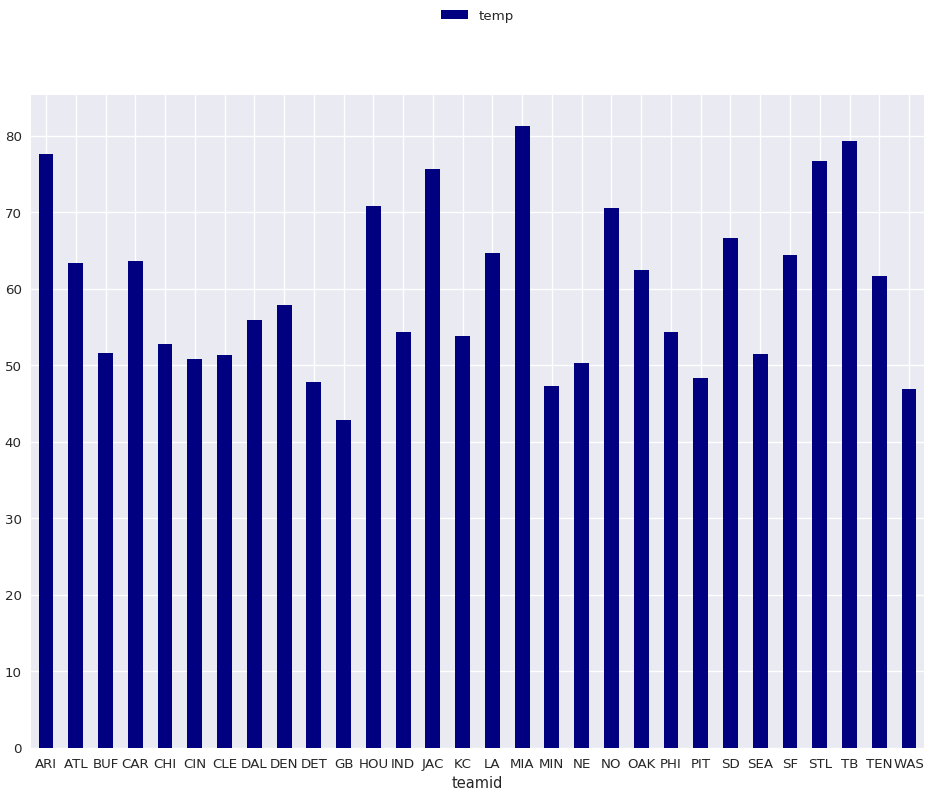

In [92]:
from pixiedust.display import *
display(data)

### Data Prep

In this case, we don't have enough of some players to cross validate our model, so we will account for that in our hyperparameter tuning.  Afterwards, we will train with the full dataset.

In [5]:
#remove rows without a temperature reading
df = df.where("not temp is Null")

#change the home column from boolean to int
df = df.withColumn('ishome', df['home'].cast('integer'))

#create some temporary tables to query players and positions that don't have many rows
df.groupBy("position").count().where('count < 10').createOrReplaceTempView("lowPosCount")
df.groupBy("name").count().where('count < 10').createOrReplaceTempView("lowNameCount")

df.createOrReplaceTempView("allRows")

#remove those low count categories to cross validate the data
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
morePlayers = spark.sql("""select * from allRows where 
                                            name not in (select name from lowNameCount) and
                                            position not in (select position from lowPosCount)""")

### Build the Spark pipeline and the Random Forest model
"Pipeline" is an API in SparkML that's used for building models.
Additional information on SparkML: https://spark.apache.org/docs/2.0.2/ml-guide.html

In [20]:
from pyspark.ml.feature import StringIndexer

#string index all string columns
nameInd = StringIndexer(inputCol="name", outputCol="nameInd")
posInd = StringIndexer(inputCol="position", outputCol="posInd")
roofInd = StringIndexer(inputCol="roof", outputCol="roofInd")
surfInd = StringIndexer(inputCol="surface", outputCol="surfInd")
stadInd = StringIndexer(inputCol="stadium_city", outputCol="stadInd")
teamInd = StringIndexer(inputCol="teamid", outputCol="teamInd")
oppInd = StringIndexer(inputCol="away_team", outputCol="oppInd")

In [21]:
from pyspark.ml.feature import OneHotEncoder

#one hot encode all indexed string columns
nameEnc = OneHotEncoder(inputCol="nameInd", outputCol="nameEnc")
posEnc = OneHotEncoder(inputCol="posInd", outputCol="posEnc")
roofEnc = OneHotEncoder(inputCol="roofInd", outputCol="roofEnc")
surfEnc = OneHotEncoder(inputCol="surfInd", outputCol="surfEnc")
stadEnc = OneHotEncoder(inputCol="stadInd", outputCol="stadEnc")
teamEnc = OneHotEncoder(inputCol="teamInd", outputCol="teamEnc")
oppEnc = OneHotEncoder(inputCol="oppInd", outputCol="oppEnc")

In [17]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#assemble a vector for all features
vecAss = VectorAssembler(
    inputCols=["nameEnc", "posEnc", "roofEnc", "surfEnc", "stadEnc", "temp", "wspd", "ishome", "teamEnc", "oppEnc"],
    outputCol="features")

In [18]:
from pyspark.ml.regression import RandomForestRegressor

#define the model
rf = RandomForestRegressor(featuresCol="features",labelCol="rushing_yds")

In [22]:
from pyspark.ml import Pipeline

#define the pipeline
pipeline = Pipeline(stages=[nameInd,nameEnc,posInd,posEnc,roofInd,roofEnc,surfInd,surfEnc,
                           stadInd,stadEnc,teamInd,teamEnc,oppInd,oppEnc,vecAss,rf])

In [17]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import datetime

#perform a grid search and cross validation to find the best hyperparameters for the model
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxBins, [40,60,80])\
    .addGrid(rf.maxDepth, [16,20,25])\
    .addGrid(rf.numTrees, [80,100,120])\
    .build()
    
evaluator = RegressionEvaluator(labelCol="rushing_yds", predictionCol="prediction", metricName="rmse")

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

print datetime.datetime.now()
cvModel = crossval.fit(morePlayers)
print datetime.datetime.now()

2017-08-30 16:27:50.974257
2017-08-30 18:32:24.184197


### Model Evaluation

In [18]:
rmse = evaluator.evaluate(cvModel.bestModel.transform(morePlayers))
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
#28.8953

Root Mean Squared Error (RMSE) on test data = 22.527


In [19]:
print cvModel.bestModel.stages[-1]._java_obj.getMaxBins()#60!
print cvModel.bestModel.stages[-1]._java_obj.getMaxDepth()#25-->
print cvModel.bestModel.stages[-1]._java_obj.getNumTrees()#<--80

60
25
80


In [23]:
#features temp wspd roof surface home stadium_city away_team name position teamid
#label rushing_yds
df = df.select('temp','wspd','roof','surface','ishome','stadium_city','away_team','name','position','teamid','rushing_yds')

In [24]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

#train the final model on all of the data
rf = RandomForestRegressor(featuresCol="features",labelCol="rushing_yds",maxBins=60,maxDepth=25,numTrees=80)
pipeline = Pipeline(stages=[nameInd,nameEnc,posInd,posEnc,roofInd,roofEnc,surfInd,surfEnc,
                           stadInd,stadEnc,teamInd,teamEnc,oppInd,oppEnc,vecAss,rf])

model = pipeline.fit(df)

In [25]:
#make some predictions
predictions = model.transform(df)
predictions.select("rushing_yds","prediction").take(10)

[Row(rushing_yds=43, prediction=35.29881331699347),
 Row(rushing_yds=95, prediction=73.93927505216902),
 Row(rushing_yds=2, prediction=5.734204333043673),
 Row(rushing_yds=1, prediction=29.297084212238115),
 Row(rushing_yds=43, prediction=34.98976840357355),
 Row(rushing_yds=46, prediction=49.27254255597158),
 Row(rushing_yds=37, prediction=32.93142857142857),
 Row(rushing_yds=9, prediction=30.32950617310642),
 Row(rushing_yds=5, prediction=6.005865968084333),
 Row(rushing_yds=25, prediction=14.34627268905398)]

### Model Deployment

In [29]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact

#save the model with WML
ml_repository_client = MLRepositoryClient()
model_artifact = MLRepositoryArtifact(model, training_data=df, name="Rushing Yards Prediction Model")

saved_model = ml_repository_client.models.save(model_artifact)

In [30]:
print saved_model.meta.available_props()
print
print "modelType: " + saved_model.meta.prop("modelType")
print "trainingDataSchema: " + str(saved_model.meta.prop("trainingDataSchema"))
print "creationTime: " + str(saved_model.meta.prop("creationTime"))
print "modelVersionHref: " + saved_model.meta.prop("modelVersionHref")
print "label: " + saved_model.meta.prop("label")

['inputDataSchema', 'evaluationMetrics', 'pipelineVersionHref', 'modelVersionHref', 'trainingDataRef', 'pipelineType', 'creationTime', 'lastUpdated', 'label', 'authorEmail', 'trainingDataSchema', 'authorName', 'version', 'modelType', 'runtime', 'evaluationMethod']

modelType: sparkml-model-2.0
trainingDataSchema: {u'fields': [{u'nullable': True, u'type': u'integer', u'name': u'temp', u'metadata': {}}, {u'nullable': True, u'type': u'integer', u'name': u'wspd', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'roof', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'surface', u'metadata': {}}, {u'nullable': True, u'type': u'integer', u'name': u'ishome', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'stadium_city', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'away_team', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'name': u'name', u'metadata': {}}, {u'nullable': True, u'type': u'string', u'n

In [31]:
loadedModelArtifact = ml_repository_client.models.get(saved_model.uid)

print str(loadedModelArtifact.name)

Rushing Yards Prediction Model


In [99]:
#AFTER THE MODEL IS DEPLOYED, make predictions with the REST api
import requests
import json

payload_scoring = {'fields': ['temp','wspd','roof','surface','ishome','stadium_city','away_team','name','position','teamid'],
                    'records': [[60,10,'Open','Voyager Bermuda Grass',1,'Bank of America Stadium','ARI','J.Stewart','QB','CAR']]}
scoring_href = 'https://internal-nginx-svc.ibm-private-cloud.svc.cluster.local:12443/v2/scoring/online/79a22c1b-8d60-4e6a-bd4b-59a760f8716d'
header = {'Content-Type': 'application/json'}
new = json.dumps(payload_scoring)
res = requests.post(scoring_href,headers=header,json=payload_scoring)

print res.json()['records'][0][-1]

7.04688548332
